# NVAR Temporal Subsampling

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

from sqgtools import XSQGTurb

In [2]:
sys.path.append("..")
from rcgfd import NVARDataset, BigPlot, plot_ke_relerr

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
nvd = NVARDataset(
    n_sub=(1,4,16),
    n_lag=(0,1,2,3)
)

In [6]:
ds = nvd()

Grab one sample for some plotting

In [7]:
xds = ds.sel(n_lag=1, n_sub=[1,4,16], sample=49)

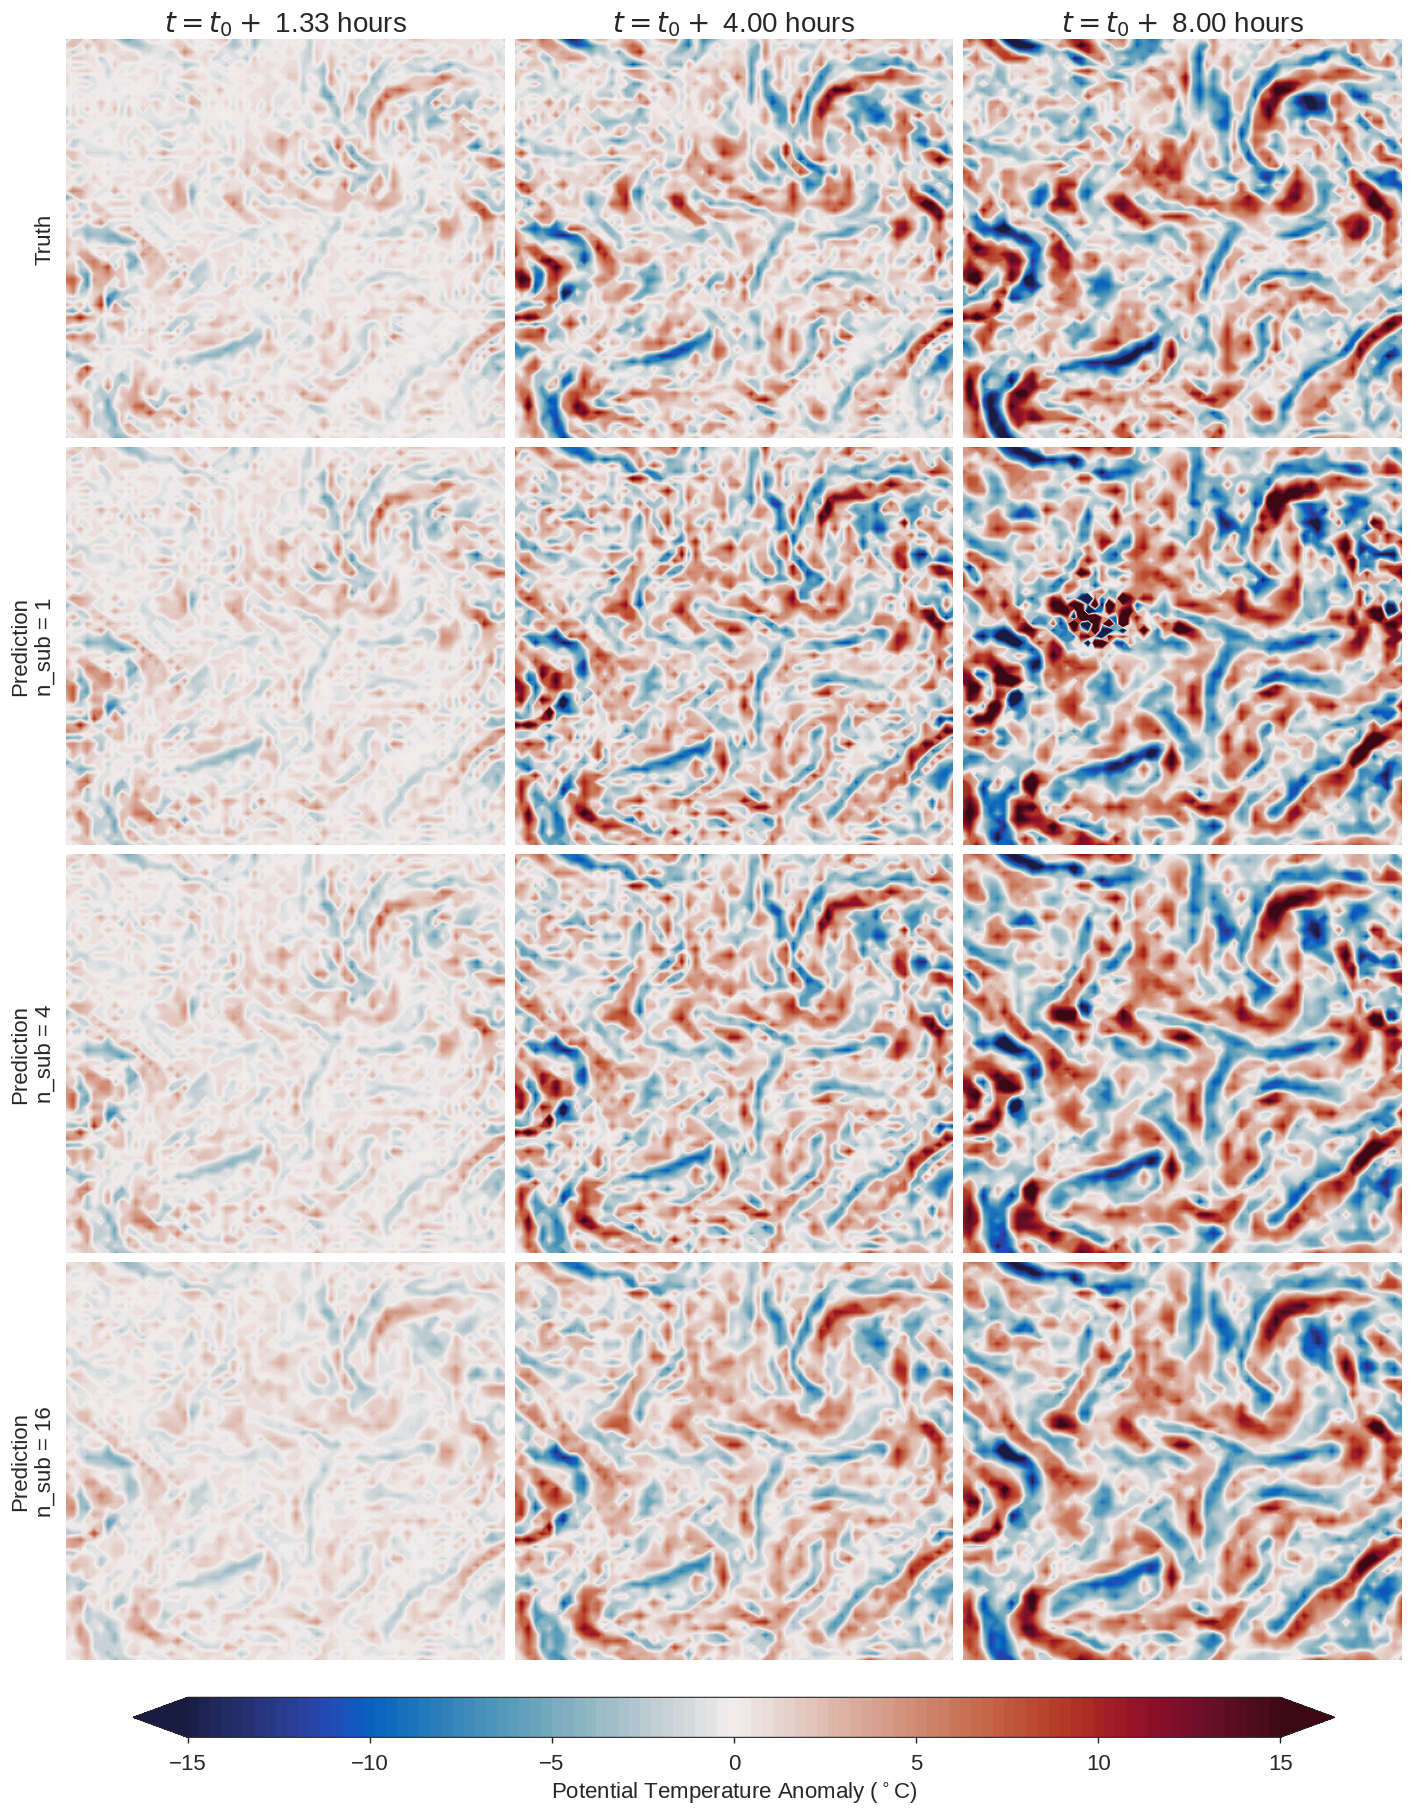

In [8]:
bp = BigPlot()
fig, axs = bp(xds)
#fig.savefig(f"{fig_dir}/nvar_big_plot.jpg", dpi=300, bbox_inches="tight")

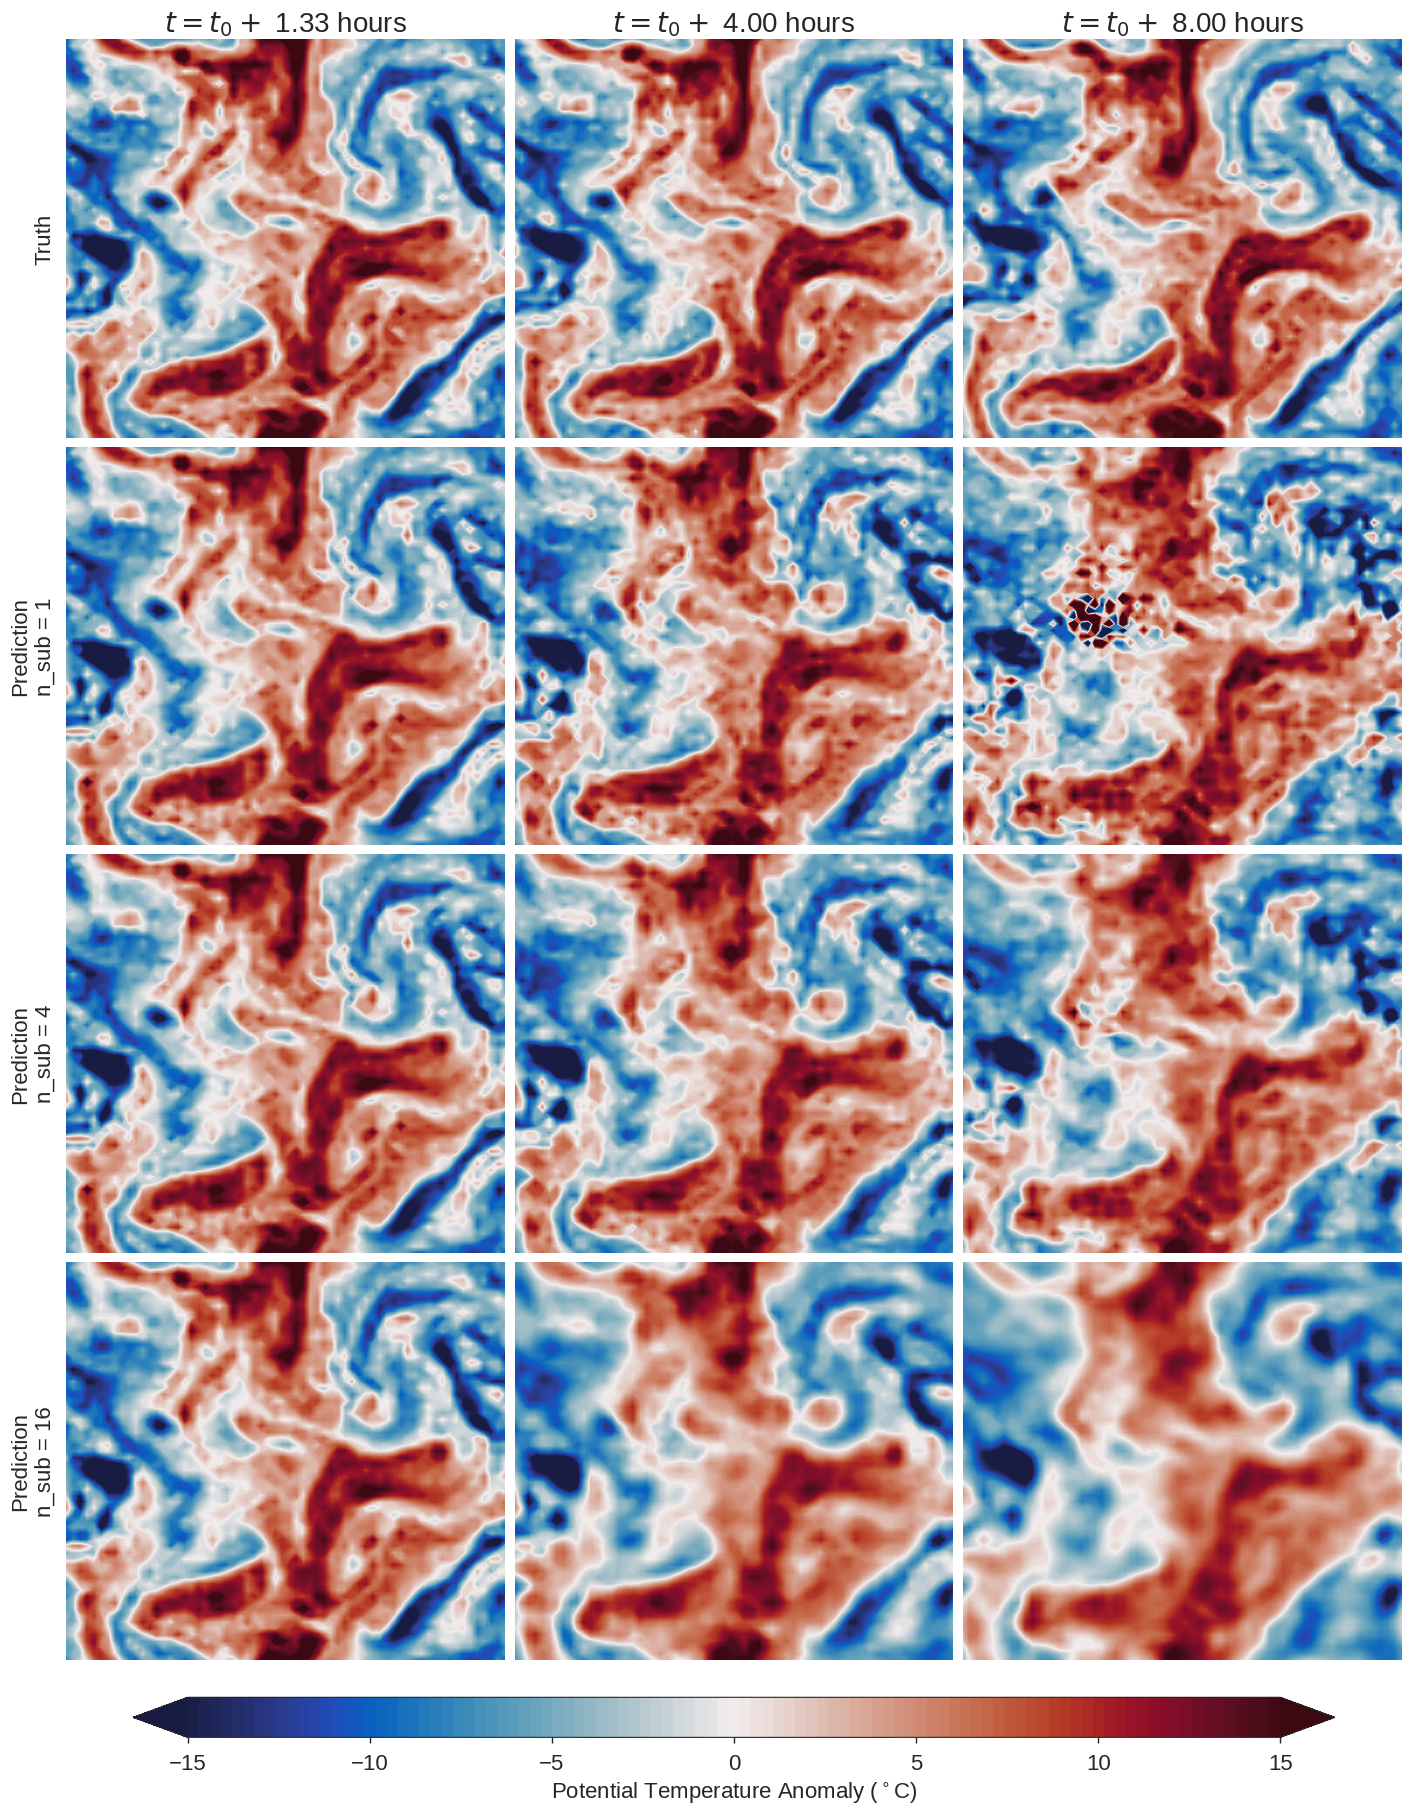

In [9]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds)

In [10]:
ep = BigPlot(prediction="absolute_error",
             cbar_label=r"Absolute Error ($^\circ C$)",
             cmap="viridis",
             plot_truth=False,
             vmax=10,
             vmin=0,
             subplot_kw={
                 "figsize":(14,14),
                 "constrained_layout": True,
             }
            )

In [11]:
#fig, axs = ep(xds)

## Spectra

In [12]:
time = np.arange(0,ds.time.max().values+1, 4800)
xds = ds.sel(n_lag=[0,1,2,3], n_sub=[1,4,16], time=bp.time)

In [13]:
xsqg = XSQGTurb()
ktrue = xsqg.calc_kespec1d(xds["truth"].load())
kpred = xsqg.calc_kespec1d(xds["prediction"].load())

In [14]:
kerr = kpred - ktrue
relerr = np.abs(kerr/ktrue)

Omit points that are off the charts

In [15]:
relerr = relerr.where(relerr.mean('sample')<=1, np.inf)

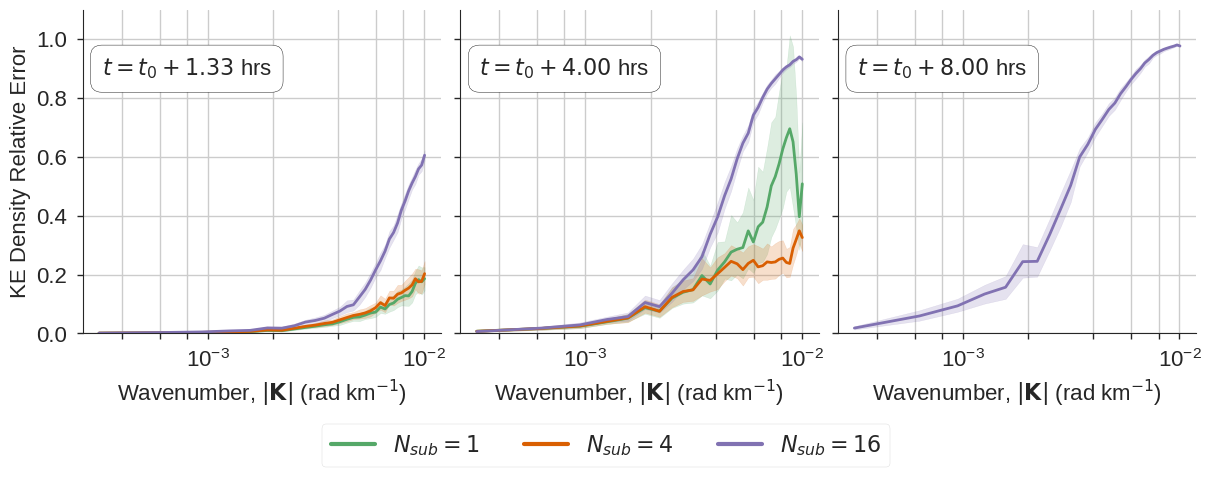

In [16]:
fig, axs = plot_ke_relerr(relerr.sel(n_lag=1), errorbar=("ci",99))
fig.savefig(f"{fig_dir}/nvar_ke_relerr.pdf", bbox_inches="tight")

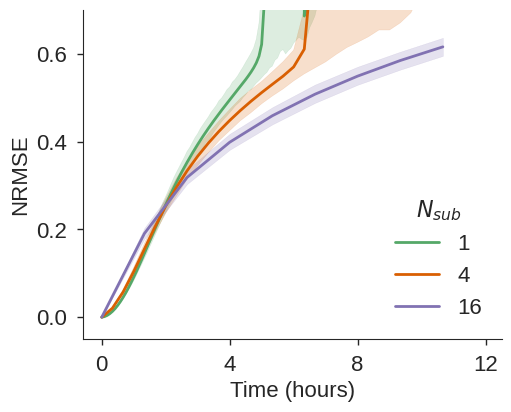

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5,4), sharex=True, constrained_layout=True)

metric = "nrmse"
for n_sub in ds.n_sub.values:
    
    plotme = ds.sel(n_lag=1, n_sub=n_sub)
    plotme = plotme[metric].to_dataset()
    df = plotme.to_dataframe().reset_index()
    sns.lineplot(
        data=df,
        x="time",
        y=metric,
        ax=ax,
        label=n_sub,
        errorbar=("ci", 95),
    )
    
ax.legend(title=r"$N_{sub}$")
hours = np.array([0,4,8,12])
seconds = hours*3600
ax.set(ylabel="NRMSE", ylim=[-.05, .7],
       xticks=seconds, xticklabels=hours, xlabel="Time (hours)")

fig.savefig(f"{fig_dir}/nvar_nrmse.pdf", bbox_inches="tight")

## Memory

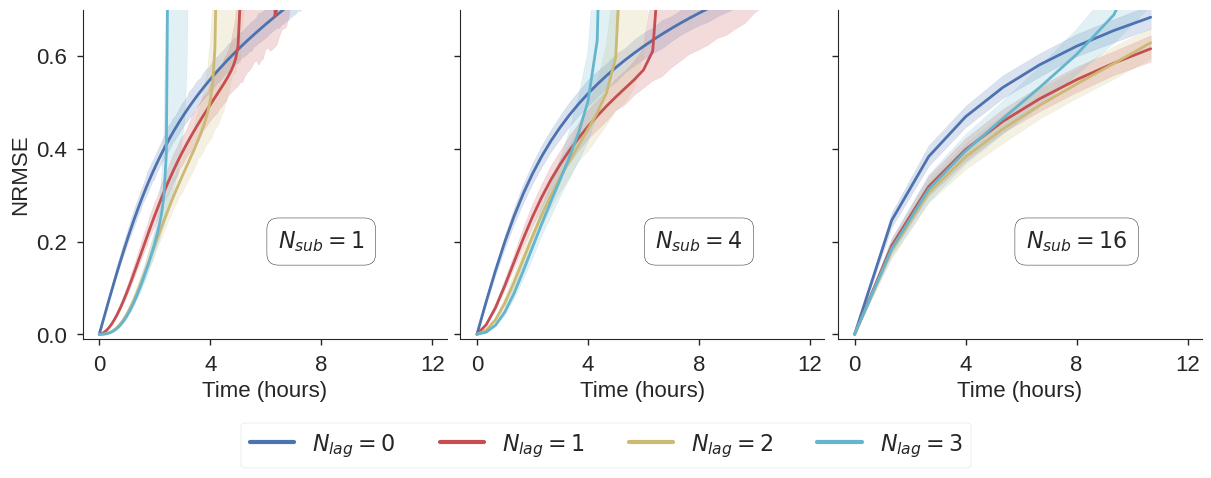

In [18]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharex=True, constrained_layout=True, sharey=True)

metric = "nrmse"
for n_sub, ax in zip(ds.n_sub.values, axs):
    for i, n_lag in enumerate(ds.n_lag.values):
        
        plotme = ds.sel(n_lag=n_lag, n_sub=n_sub)
        plotme = plotme[metric].to_dataset()
        df = plotme.to_dataframe().reset_index()
        sns.lineplot(
            data=df,
            x="time",
            y=metric,
            ax=ax,
            label=r"$N_{lag} = %d$" % n_lag,
            errorbar=("ci", 99),
            color=f"C{i+3}",
        )
        
    ax.set(ylabel="")
    ax.legend(title=xds[metric].label)
    hours = np.array([0,4,8,12])
    seconds = hours*3600
    ax.set(xticks=seconds, xticklabels=hours, xlabel="Time (hours)")
    ax.set(ylim=[-0.01, 0.7])
    ax.text(
        8*3600, 0.2,"$N_{sub} = %d$" % n_sub,
        ha="center",
        va="center",
        transform=ax.transData,
        bbox={
            "facecolor": "white",
            "edgecolor": "black",
            "boxstyle": "round,pad=.5",
        },
    )
    leg = ax.get_legend()
    leg.remove()
    if ax.get_subplotspec().is_first_col():
        leg = fig.legend(
            loc="center",
            bbox_to_anchor=(0.5,-0.1),
            ncol=4,
            frameon=True,
        )
        # Make legend handle linewidth bigger
        [l.set_linewidth(3) for l in leg.legendHandles]
        ax.set(ylabel="NRMSE")
        
fig.savefig(f"{fig_dir}/nvar_nrmse_vs_memory.pdf", bbox_inches="tight")

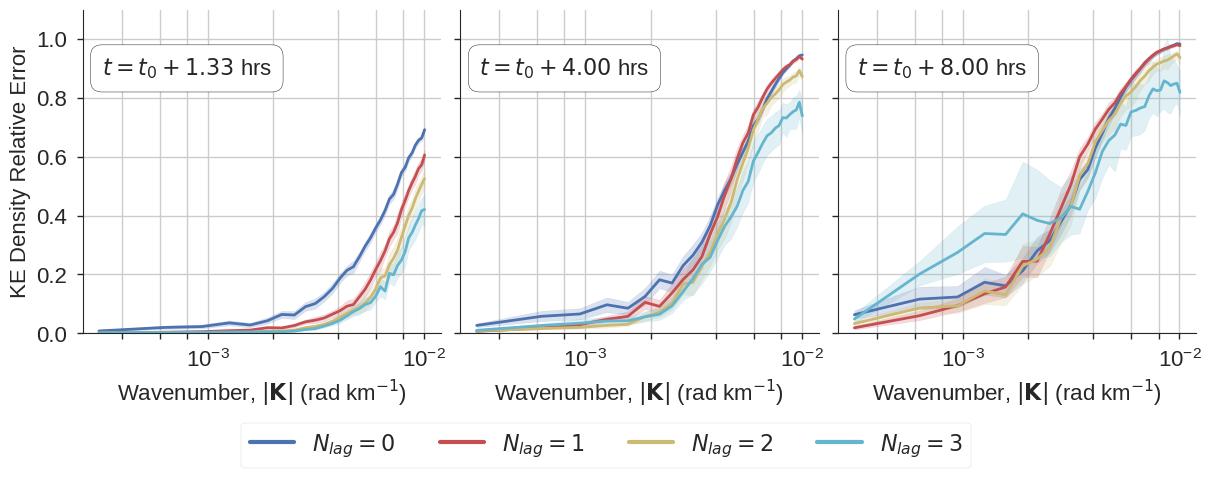

In [20]:
fig, axs = plot_ke_relerr(relerr.sel(n_sub=16),
                          errorbar=("ci", 99),
                          cdim="n_lag",
                          clabel=lambda n_lag:r"$N_{lag} = %d$" % n_lag)
fig.savefig(f"{fig_dir}/nvar_ke_relerr_vs_lag.pdf", bbox_inches="tight")